In [1]:
import pandas as pd

## import data

In [2]:
hrst_st_rsex=pd.read_csv('data/hrst_st_rsex_page_linear.csv')

In [3]:
lfsa_ewhais=pd.read_csv('data/lfsa_ewhais_page_linear.csv')

In [4]:
prc_ppp_ind=pd.read_csv('data/prc_ppp_ind_page_linear.csv')

In [5]:
sbs_ovw_act=pd.read_csv('data/sbs_ovw_act_page_linear.csv')

## process data

In [6]:
hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')#.assign(ratio=F/T)

sex,F,T
geo,,
AT,899.6,1796.1
BA,159.6,312.9
BE,1086.9,2065.6
BG,479.8,824.3
CH,1011.8,2048.5
CY,90.5,170.8
CZ,892.7,1812.6
DE,9415.9,18139.5
DK,703.3,1399.9


In [17]:
def process_csv(df):
    return df.set_index('geo')[['OBS_VALUE']]

In [18]:
lfsa_ewhais.pipe(process_csv)

,OBS_VALUE
geo,
AT,33.6
BA,41.4
BE,34.9
BG,39.0
CH,36.2
CY,38.5
CZ,37.8
DE,34.0
DK,34.3


In [44]:
merged_stats=(lfsa_ewhais
 .pipe(process_csv)
 .merge(prc_ppp_ind
        .pipe(process_csv),
        left_index=True, 
        right_index=True,
        suffixes=('_lfsa_ewhais', '_prc_ppp_ind')
       )
 .merge(sbs_ovw_act
        .pipe(process_csv),
        left_index=True, 
        right_index=True,
        suffixes=('', '_sbs_ovw_act')
       )
              .reset_index()
              .query('geo!="EU27_2020"')
              .set_index('geo')
             )

In [45]:
# normalized_df=(df-df.min())/(df.max()-df.min())


In [48]:
minmax_normalised_stats=(merged_stats-merged_stats.min(numeric_only=True))/(merged_stats.max(numeric_only=True)-merged_stats.min(numeric_only=True))


In [49]:
minmax_normalised_stats

,OBS_VALUE_lfsa_ewhais,OBS_VALUE_prc_ppp_ind,OBS_VALUE
geo,,,
AT,0.147368,0.104843,0.084115
BE,0.284211,0.133622,0.100104
BG,0.715789,0.043274,0.030555
CY,0.663158,0.004649,0.021477
CZ,0.589474,0.083822,0.170359
DE,0.189474,1.000000,0.549482
DK,0.221053,0.062298,0.105421
EE,0.442105,0.006039,0.020405
EL,0.800000,0.080706,0.108884


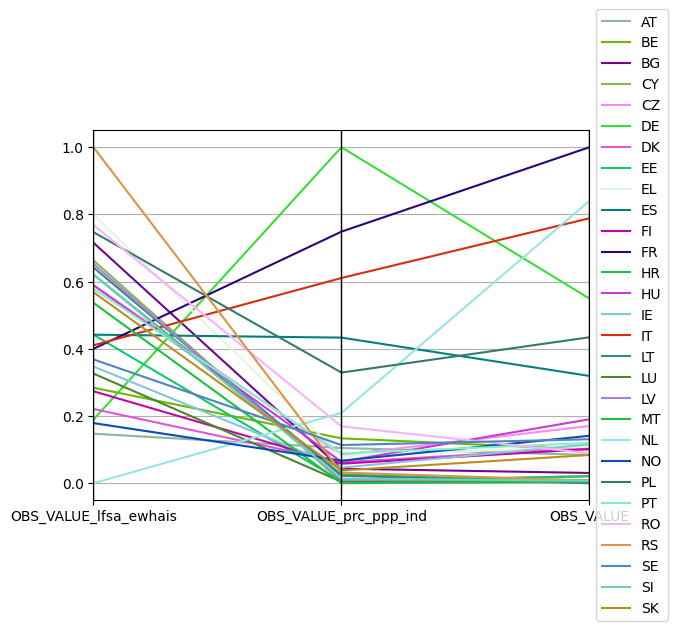

In [50]:
pd.plotting.parallel_coordinates(minmax_normalised_stats.reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

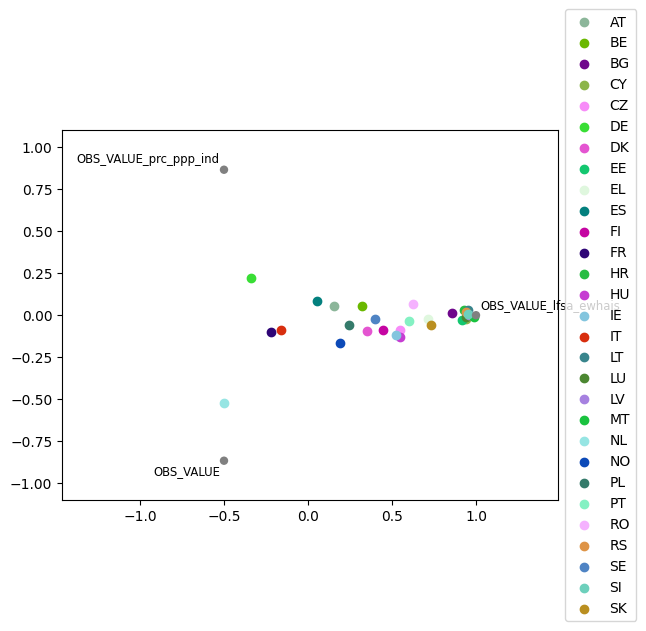

In [51]:
pd.plotting.radviz(minmax_normalised_stats.reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
